## Tutorial: marginalization

Hopefully by now you have a clear idea of what the PHOEBE bundle looks like and how many parameters go into a single model computation. We also saw in the parametrization tutorial that certain parameters are not sensitive to certain data.

#### Case 1: parameters insensitive to data

So let's look at the one light curve scenario. As we've seen before, a light curve does not constrain well parameters related to individual masses,  radii and temperatures. So when we reparametrize to fit for the sum and ratio of fractional radii and the temperature ratio, should we omit q, sma@binary and teff@primary from the fitted parameters? 

**== DISCUSSION ON SLACK ==**

In [1]:
import numpy as np
import phoebe
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
lc = np.loadtxt('data/synthetic/lc.data')

b = phoebe.load('data/synthetic/true.bundle')
b.add_dataset('lc', times=lc[:,0], fluxes=lc[:,1], sigmas=lc[:,2], passband='Johnson:V')

b.set_value('pblum_mode', 'dataset-scaled')
b.set_value_all('irrad_method', 'none')

In [3]:
b.flip_constraint('q', solve_for='mass@secondary')
b.flip_constraint('sma@binary', solve_for='mass@primary') # optional since lc also doesn't constrain sma

b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')

b.flip_constraint('requivsumfrac', solve_for='requiv@primary@component')
b.flip_constraint('requivratio', solve_for='requiv@secondary@component')
b.flip_constraint('teffratio', solve_for='teff@secondary@component')

<ConstraintParameter: {teff@secondary@component} = {teffratio@binary@component} * {teff@primary@component} (solar units) => 5610.0 K>

We'll need the true values to compare our solutions later:

In [106]:
true_values = [
    b.get_value('requivsumfrac', context='component'),    
    b.get_value('requivratio', context='component'),
    b.get_value('teffratio', context='component'),
    b.get_value('incl', context='component', component='binary'),
    b.get_value('q', context='component'),
    b.get_value('sma', context='component', component='binary'),
    b.get_value('teff', context='component', component='primary'),
    -5
]

**fixing the parameters (to wrong values)**

Let's first see what happens when we omit q, sma and teff from the sampled parameters, but instead of setting them to their true values, like in the parametrization tutorial, we'll fix them to some incorrect values.

In [4]:
b.set_value('q', 1.)
b.set_value('sma@binary', 15.)
b.set_value('teff@primary', 7500)

100%|██████████| 200/200 [00:06<00:00, 31.76it/s]


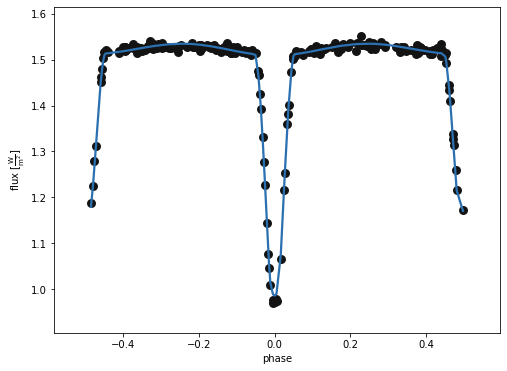

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [5]:
b.run_compute()
b.plot(x='phase', show=True)

As expected, changing these values did not have a huge effect on the light curve. Let's initialize a sample only around the true values that the light curve is sensitive to *(we'll omit esinw and ecosw here because we know it's a circular system and sampling takes much faster if the orbit is not eccentric)*:

In [6]:
b.add_distribution({
    'requivsumfrac': phoebe.gaussian_around(0.01),
    'requivratio': phoebe.gaussian_around(0.1),
    'teffratio': phoebe.gaussian_around(0.1),
    'incl@binary': phoebe.gaussian_around(0.01)
}, distribution='fixed_wrong')

<ParameterSet: 4 parameters | qualifiers: requivsumfrac, incl, requivratio, teffratio>

_________________________________________

In [18]:
# b.add_server('remoteslurm', crimpl_name='clusty', nprocs=48, walltime=48,
#              use_conda=True, conda_env='phoebe-workshop',
#              server='clusty')

In [19]:
# b.add_solver('sampler.emcee', solver='mcmc_fixed_wrong',
#               init_from='fixed_wrong',
#               compute='phoebe01', nwalkers=48, niters=500, progress_every_niters=50)

In [20]:
# b.run_solver('mcmc_fixed_wrong', use_server='clusty', solution='mcmc_fixed_wrong_solution', detach=True)

______________________________________________________

**marginalizing over parameters**

Let's see what happens when we include these additional three parameters in the sample. Since our data is not directly sensitive to them, we'll give them a wider initial sampling distribution.

In [10]:
b.add_distribution({
    'requivsumfrac': phoebe.gaussian_around(0.01),
    'requivratio': phoebe.gaussian_around(0.1),
    'teffratio': phoebe.gaussian_around(0.1),
    'incl@binary': phoebe.gaussian_around(0.5),
    'q': phoebe.gaussian_around(0.25),
    'sma@binary': phoebe.gaussian_around(5),
    'teff@primary': phoebe.gaussian_around(500)
}, distribution='marginalization')

<ParameterSet: 7 parameters | components: primary, binary>

In [16]:
# b.add_solver('sampler.emcee', solver='mcmc_marginalization',
#               init_from='marginalization',
#               compute='phoebe01', nwalkers=48, niters=500, progress_every_niters=50)

In [17]:
# b.run_solver('mcmc_marginalization', use_server='clusty', solution='mcmc_marginalization_solution', detach=True)

In [15]:
# b.load_job_progress(solution='mcmc_fixed_wrong_solution')

In [114]:
# b.save('data/synthetic/true_marginalization_case1.bundle')

In [113]:
# b = phoebe.load('data/synthetic/true_marginalization_case1.bundle')
# b.load_job_progress(solution='mcmc_fixed_wrong_solution')
# b.load_job_progress(solution='mcmc_marginalization_solution')
# b.plot(solution='mcmc_fixed_wrong_solution', style='trace', burnin=0, show=True)
# b.plot(solution='mcmc_marginalization_solution', style='trace', burnin=0, show=True)
# # b.save('data/synthetic/true_marginalization_case1.bundle')

(None, <Figure size 698.4x698.4 with 16 Axes>)

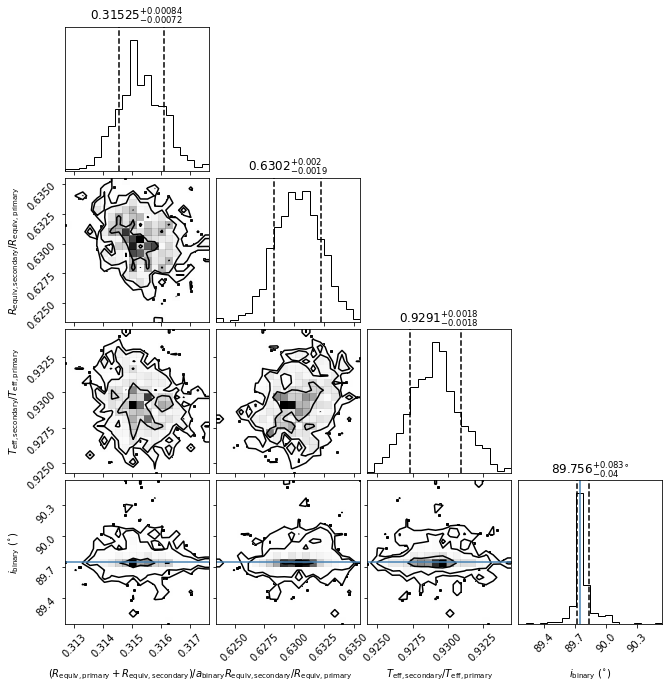

In [79]:
b.plot(solution='mcmc_fixed_wrong_solution', style='corner', burnin=50, truths=true_values[:4], show=True)

(None, <Figure size 1152x1152 with 49 Axes>)

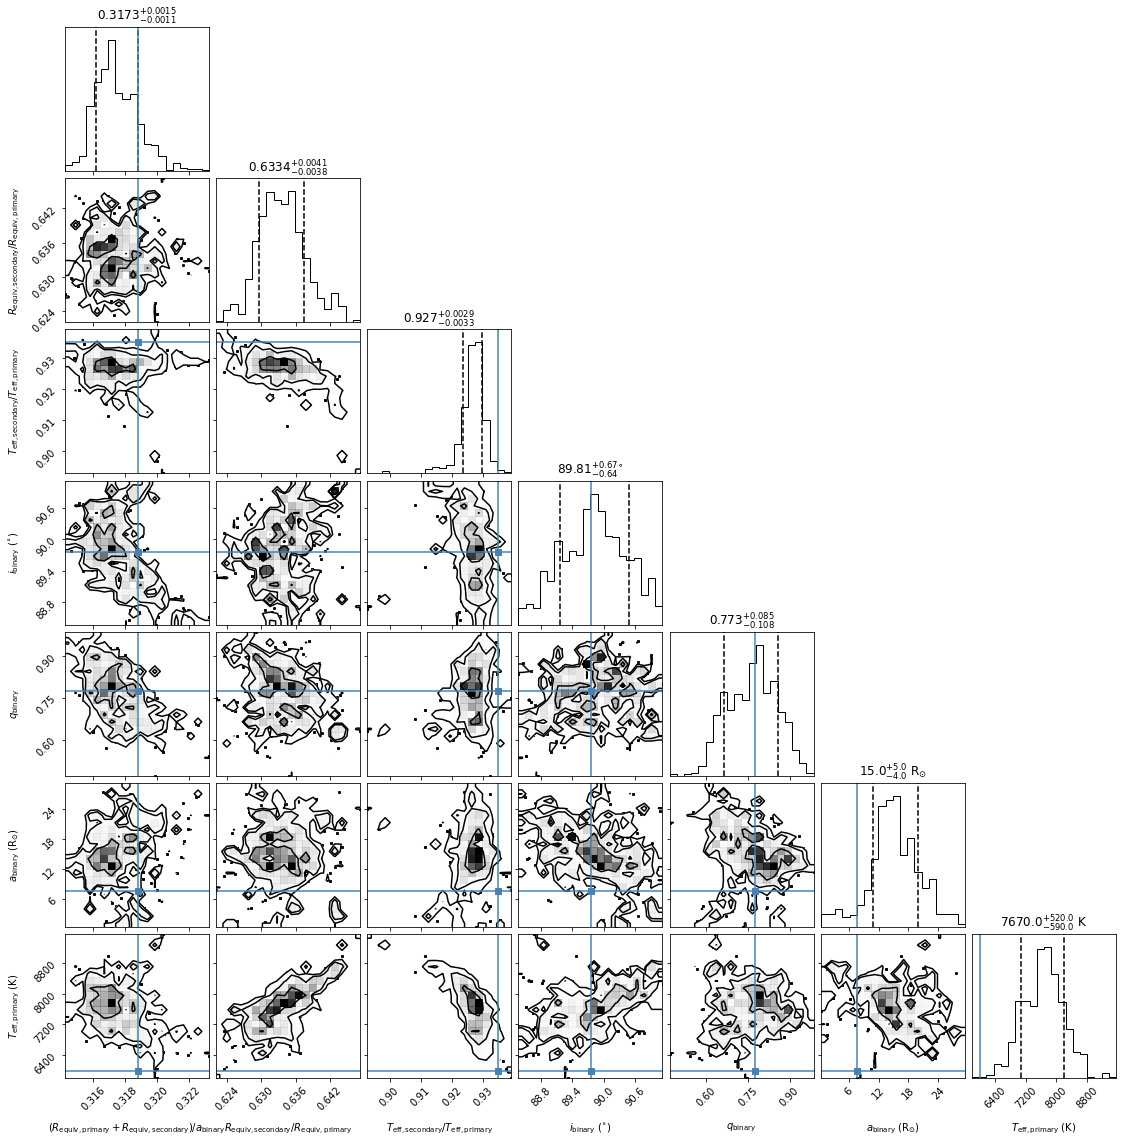

In [82]:
b.plot(solution='mcmc_marginalization_solution', style='corner', burnin=50, truths=true_values[:-1], show=True)

#### Case 2: noise nuisance parameter

Let's again assume a case where you only have a light curve, but the assigned observational errors to the fluxes appear under-estimated. The underlying log-likelihood cares about data uncertainties and this is bound to affect your solution, especially if you don't have a lot of (overlapping) points in the eclipses. 

Let's again use the true bundle to remove all other contributions to the solution and attach a light curve of the same system we've been using, only this time the light curve is noiser, we'll less observations, but the observational uncertainties are under-estimated.

In [21]:
lc = np.loadtxt('data/synthetic/lc_noisy.data')

b = phoebe.load('data/synthetic/true.bundle')
b.add_dataset('lc', times=lc[:,0], fluxes=lc[:,1], sigmas=lc[:,2], passband='Johnson:V')

b.set_value('pblum_mode', 'dataset-scaled')

In [22]:
b.flip_constraint('q', solve_for='mass@secondary')
b.flip_constraint('sma@binary', solve_for='mass@primary') # optional since lc also doesn't constrain sma

b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')

b.flip_constraint('requivsumfrac', solve_for='requiv@primary@component')
b.flip_constraint('requivratio', solve_for='requiv@secondary@component')
b.flip_constraint('teffratio', solve_for='teff@secondary@component')

<ConstraintParameter: {teff@secondary@component} = {teffratio@binary@component} * {teff@primary@component} (solar units) => 5610.0 K>

100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


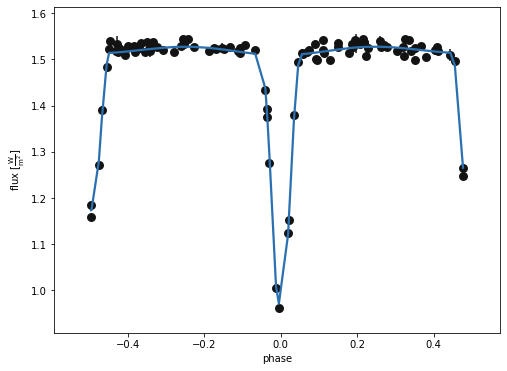

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [23]:
b.run_compute()
b.plot(x='phase', show=True)

Now let's try sampling around the true values and see what happens:

In [24]:
b.add_distribution({
    'requivsumfrac': phoebe.gaussian_around(0.01),
    'requivratio': phoebe.gaussian_around(0.1),
    'teffratio': phoebe.gaussian_around(0.1),
    'incl@binary': phoebe.gaussian_around(0.5)
}, distribution='nonoisenuis')

<ParameterSet: 4 parameters | qualifiers: requivsumfrac, incl, requivratio, teffratio>

In [109]:
# b.add_server('remoteslurm', crimpl_name='terra', nprocs=48, walltime=48,
#              use_conda=True, conda_env='phoebe-workshop',
#              server='terra')

In [110]:
# b.add_solver('sampler.emcee', solver='mcmc_nonoisenuis',
#               init_from='nonoisenuis',
#               compute='phoebe01', nwalkers=48, niters=1000, progress_every_niters=50)

In [111]:
# b.run_solver('mcmc_nonoisenuis', use_server='terra', solution='mcmc_nonoisenuis_solution', detach=True)

And another run with the noise nuisance parameter:

In [28]:
b.add_distribution({
    'requivsumfrac': phoebe.gaussian_around(0.01),
    'requivratio': phoebe.gaussian_around(0.1),
    'teffratio': phoebe.gaussian_around(0.1),
    'incl@binary': phoebe.gaussian_around(0.5),
    'sigmas_lnf@lc01': phoebe.gaussian(-7,1)
}, distribution='withnoisenuis')

<ParameterSet: 5 parameters | qualifiers: sigmas_lnf, requivsumfrac, requivratio, incl, teffratio>

In [35]:
# b.add_solver('sampler.emcee', solver='mcmc_withnoisenuis',
#               init_from='withnoisenuis',
#               compute='phoebe01', nwalkers=48, niters=1000, progress_every_niters=50)

In [34]:
# b.run_solver('mcmc_withnoisenuis', use_server='terra', solution='mcmc_withnoisenuis_solution', detach=True)

In [33]:
#b.save('data/synthetic/true_marginalization_case2.bundle')

In [112]:
# b = phoebe.load('data/synthetic/true_marginalization_case2.bundle')
# b.load_job_progress(solution='mcmc_nonoisenuis_solution')
# b.load_job_progress(solution='mcmc_withnoisenuis_solution')
# b.plot(solution='mcmc_nonoisenuis_solution', style='trace', burnin=0, show=True)
# b.plot(solution='mcmc_withnoisenuis_solution', style='trace', burnin=0, show=True)
# b.save('data/synthetic/true_marginalization_case2.bundle')

(None, <Figure size 698.4x698.4 with 16 Axes>)

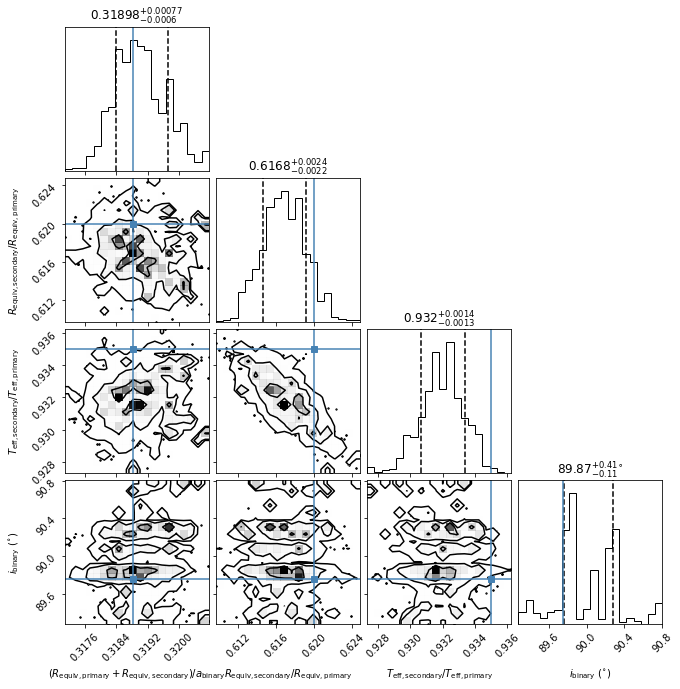

In [90]:
b.plot(solution='mcmc_nonoisenuis_solution', style='corner', truths=true_values[:4], burnin=100, show=True)

(None, <Figure size 849.6x849.6 with 25 Axes>)

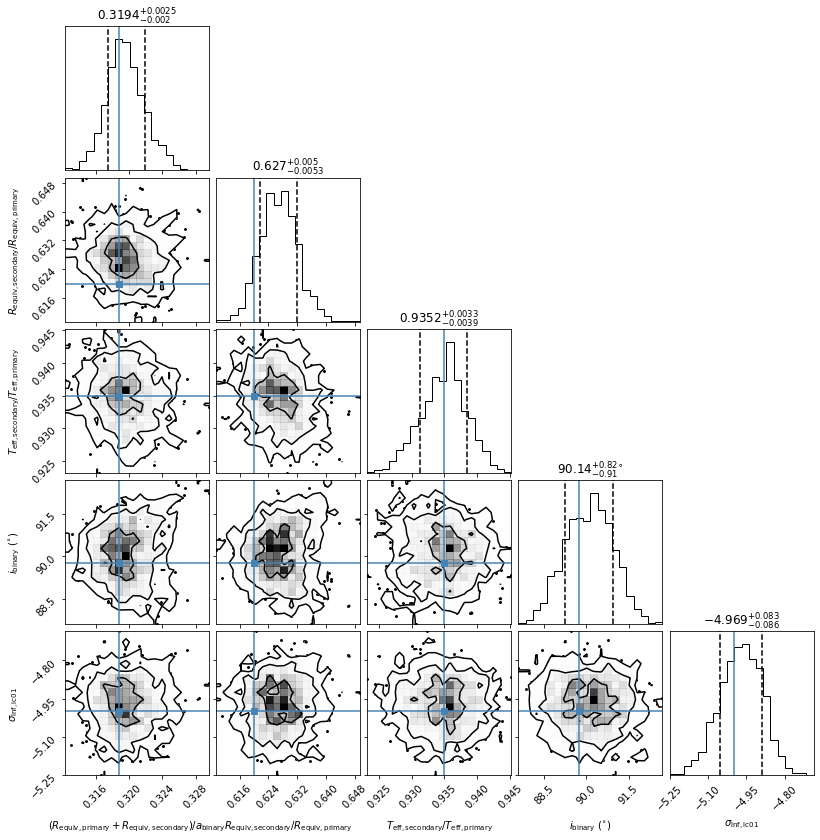

In [108]:
b.plot(solution='mcmc_withnoisenuis_solution', style='corner', burnin=100, truths=true_values[:4]+[true_values[-1]], lnprob_cutoff=375, show=True)